In [9]:
from pycbc import distributions
from pycbc.waveform import get_td_waveform
from pycbc.filter import sigma
from pycbc.psd import aLIGOZeroDetHighPower
import pycbc.noise
import numpy as np
from gwpy.timeseries import TimeSeries
from tqdm import tqdm
import os

# === Parameters ===
n_samples = 5000
fs = 4096
duration = 4.0
delta_t = 1.0 / fs
tsamples = int(duration * fs)
flow = 30.0
target_snr_range = (5, 8)

# === Output directories ===
base_dir = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/"
dirs = {
    "signal": os.path.join(base_dir, "BBH/"),
    "noise": os.path.join(base_dir, "noise_template/"),
    "injected": os.path.join(base_dir, "noise-injected-signal/")
}
for d in dirs.values():
    os.makedirs(d, exist_ok=True)

# === PSD for colored noise generation (fixed) ===
delta_f_noise = 1.0 / duration  # 0.25 Hz
flen_noise = int(2048 / delta_f_noise) + 1
psd_noise = aLIGOZeroDetHighPower(flen_noise, delta_f_noise, flow)
psd_noise[psd_noise == 0] = 1e-40
psd_noise = pycbc.types.FrequencySeries(psd_noise, delta_f=delta_f_noise)

# === Mass distribution ===
mass_dist = distributions.Uniform(mass1=(10, 100), mass2=(10, 100))

# === Injection loop ===
valid_count = 0
max_attempts = 10000
i = 0

while valid_count < n_samples and i < max_attempts:
    try:
        # Sample random BBH masses
        m1, m2 = mass_dist.rvs(size=1)[0]
        distance = 1
        inclination = np.random.uniform(0, np.pi)
        spin1z = np.random.uniform(-0.99, 0.99)
        spin2z = np.random.uniform(-0.99, 0.99)

        # Generate waveform
        hp, _ = get_td_waveform(approximant="SEOBNRv2",
                                mass1=m1,
                                mass2=m2,
                                delta_t=delta_t,
                                f_lower=40.0,
                                distance=distance,
                                inclination=inclination,
                                spin1z=spin1z,
                                spin2z=spin2z)

        # Frequency domain waveform
        ht = hp.to_frequencyseries()

        # === NEW: PSD for SNR scaling (match delta_f) ===
        delta_f_sigma = ht.delta_f
        flen_sigma = int(2048 / delta_f_sigma) + 1
        psd_sigma = aLIGOZeroDetHighPower(flen_sigma, delta_f_sigma, flow)
        psd_sigma[psd_sigma == 0] = 1e-40
        psd_sigma = pycbc.types.FrequencySeries(psd_sigma, delta_f=delta_f_sigma)

        # Calculate original SNR
        snr_orig = sigma(ht, psd=psd_sigma, low_frequency_cutoff=40.0)

        if not np.isfinite(snr_orig) or snr_orig == 0:
            i += 1
            continue

        # Random target SNR and scale
        target_snr = np.random.randint(*target_snr_range)
        hp *= target_snr / snr_orig

        # Generate colored noise using fixed PSD
        noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd_noise)
        noise_ts = TimeSeries.from_pycbc(noise)

        # Convert waveform to TimeSeries and shift to injection time
        signal_ts = TimeSeries.from_pycbc(hp)
        injection_time = np.random.choice([1, 1.5, 2, 2.5, 3])
        signal_ts.t0 = injection_time

        # Inject signal into noise
        injected_ts = noise_ts.inject(signal_ts)

        # Save all components
        signal_ts.write(os.path.join(dirs["signal"], f"bbh_4k_{valid_count}.txt"))
        noise_ts.write(os.path.join(dirs["noise"], f"noise_4k_{valid_count}.txt"))
        injected_ts.write(os.path.join(dirs["injected"], f"merged_noise_signal_{valid_count}.txt"))

        valid_count += 1

    except Exception as e:
        print(f"Skipping sample {i}: {e}")

    i += 1

if valid_count < n_samples:
    print(f"⚠️ Only generated {valid_count} samples after {max_attempts} attempts.")


/usr/local/lib/python3.8/dist-packages/pycbc/scheme.py:194: RuntimeWarning: divide by zero encountered in divide
  return _import_cache[mgr.state][func](*args, **kwds)
/usr/local/lib/python3.8/dist-packages/pycbc/scheme.py:194: RuntimeWarning: invalid value encountered in divide
  return _import_cache[mgr.state][func](*args, **kwds)


In [10]:
from pycbc import distributions
from pycbc.waveform import get_td_waveform
from pycbc.filter import sigma
from pycbc.psd import aLIGOZeroDetHighPower
import pycbc.noise
import numpy as np
from gwpy.timeseries import TimeSeries
from tqdm import tqdm
import os

# === Parameters ===
n_val_samples = 1000
fs = 4096
duration = 4.0
delta_t = 1.0 / fs
tsamples = int(duration * fs)
flow = 30.0
snr_range = (4, 10)

# === Directories ===
val_dir = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files-enhanced-data-generation/"
dirs = {
    "noise": os.path.join(val_dir, "noise"),
    "injected": os.path.join(val_dir, "injected")
}
for d in dirs.values():
    os.makedirs(d, exist_ok=True)

# === Shared PSD for noise generation ===
delta_f_noise = 1.0 / duration
flen_noise = int(2048 / delta_f_noise) + 1
shared_psd = aLIGOZeroDetHighPower(flen_noise, delta_f_noise, flow)
shared_psd[shared_psd == 0] = 1e-40
shared_psd = pycbc.types.FrequencySeries(shared_psd, delta_f=delta_f_noise)

# === Mass distribution ===
mass_dist = distributions.Uniform(mass1=(10, 50), mass2=(10, 50))
mass_samples = mass_dist.rvs(size=n_val_samples)

# === Generation loop ===
generated = 0
attempts = 0
max_attempts = 3000  # Safety cap

while generated < n_val_samples and attempts < max_attempts:
    attempts += 1
    try:
        # === Sample masses and SNR dynamically ===
        m1, m2 = np.random.uniform(10, 50, size=2)
        target_snr = np.random.randint(*snr_range)
        distance = 1 
        inclination = np.random.uniform(0, np.pi)
        spin1z = np.random.uniform(-0.99, 0.99)
        spin2z = np.random.uniform(-0.99, 0.99)

        # Generate waveform
        hp, _ = get_td_waveform(approximant="SEOBNRv2",
                                mass1=m1,
                                mass2=m2,
                                delta_t=delta_t,
                                f_lower=40.0,
                                distance=distance,
                                inclination=inclination,
                                spin1z=spin1z,
                                spin2z=spin2z)

        # PSD for scaling (matched to waveform length)
        delta_f_wave = 1.0 / hp.duration
        flen_wave = int(2048 / delta_f_wave) + 1
        psd_wave = aLIGOZeroDetHighPower(flen_wave, delta_f_wave, flow)
        psd_wave[psd_wave == 0] = 1e-40
        psd_wave = pycbc.types.FrequencySeries(psd_wave, delta_f=delta_f_wave)

        ht = hp.to_frequencyseries()
        snr_orig = sigma(ht, psd=psd_wave, low_frequency_cutoff=40.0)

        if not np.isfinite(snr_orig) or snr_orig == 0:
            continue

        hp *= target_snr / snr_orig

        noise = pycbc.noise.noise_from_psd(tsamples, delta_t, shared_psd)
        noise_ts = TimeSeries.from_pycbc(noise)

        signal_ts = TimeSeries.from_pycbc(hp)
        injection_time = np.random.choice([1, 1.5, 2, 2.5, 3])
        signal_ts.t0 = injection_time

        injected_ts = noise_ts.inject(signal_ts)

        # Save
        noise_ts.write(f"{dirs['noise']}/val_noise_{generated}.txt")
        injected_ts.write(f"{dirs['injected']}/val_injected_{generated}.txt")

        generated += 1

    except Exception as e:
        print(f"⚠️ Skipping sample {generated} (attempt {attempts}): {e}")

if generated < n_val_samples:
    print(f"⚠️ Only generated {generated} samples after {attempts} attempts.")
else:
    print("✅ Validation dataset generation complete.")


✅ Validation dataset generation complete.


In [11]:
import csv
import pandas as pd

In [12]:
#Merging the injected signal into single CSV file
path = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/noise-injected-signal/"
files= os.listdir(path)
f = open("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 5000/5000 [09:40<00:00,  8.62it/s] 


In [13]:
#Merging the noise into single CSV file
path = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/noise_template/"
files= os.listdir(path)
f = open("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_Merged_Noise_Reduced_No_Abs.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    if 1 in df.columns:
        c = df[1]
    else:
        c = df[0]
    #c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 5000/5000 [08:44<00:00,  9.54it/s]


In [14]:
#Merging the signal into single CSV file
path = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/BBH/"
files= os.listdir(path)
f = open("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_Merged_bbh_Signal_Reduced_No_Abs.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 5000/5000 [01:44<00:00, 47.85it/s] 


In [15]:
path = val_dir+"injected/"
files= os.listdir(path)
f = open(val_dir+'val_Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 1000/1000 [02:16<00:00,  7.33it/s]


In [16]:
path_1 = val_dir+"noise/"
files_1= os.listdir(path_1)
f1 = open(val_dir+'val_Final_Merged_Noise_Reduced_No_Abs.csv', 'w')
cw_1 = csv.writer(f1)

for i in tqdm(files_1):
    #print(files)
    df = pd.read_csv(path_1+i,sep = ' ', header=None)
    c = df[:][1]
    cw_1.writerow(c)
f1.close()

100%|██████████| 1000/1000 [02:23<00:00,  6.98it/s]


2025-07-24 14:34:21.334235: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 14:34:21.607977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 14:36:39.530739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-24 14:36:39.571345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bu

Epoch 1/30


2025-07-24 14:36:52.280101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-07-24 14:36:53.369775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-24 14:36:53.436533: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x76c98bcfa3a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-24 14:36:53.436622: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-07-24 14:36:53.464022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-24 14:36:53.658430: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

313/313 [==============================] - 28s 72ms/step - loss: 0.6022 - accuracy: 0.6605 - val_loss: 36.5590 - val_accuracy: 0.5000
Epoch 2/30
313/313 [==============================] - 19s 62ms/step - loss: 0.4556 - accuracy: 0.7933 - val_loss: 1.1221 - val_accuracy: 0.5625
Epoch 3/30
313/313 [==============================] - 22s 70ms/step - loss: 0.4025 - accuracy: 0.8238 - val_loss: 5.6981 - val_accuracy: 0.5000
Epoch 4/30
313/313 [==============================] - 43s 137ms/step - loss: 0.3790 - accuracy: 0.8362 - val_loss: 2.8794 - val_accuracy: 0.5010
Epoch 5/30
313/313 [==============================] - 68s 217ms/step - loss: 0.3496 - accuracy: 0.8521 - val_loss: 1.0619 - val_accuracy: 0.6070
Epoch 6/30
313/313 [==============================] - 70s 223ms/step - loss: 0.3338 - accuracy: 0.8576 - val_loss: 0.5034 - val_accuracy: 0.8015
Epoch 7/30
313/313 [==============================] - 71s 226ms/step - loss: 0.3124 - accuracy: 0.8704 - val_loss: 0.5048 - val_accuracy: 0.762

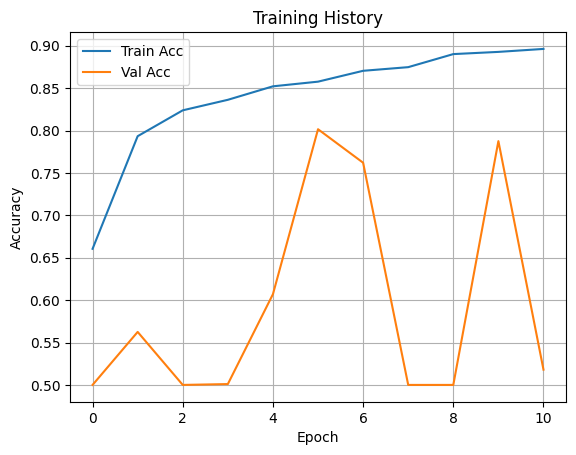

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU, Dropout,
                                     MaxPooling1D, GlobalAveragePooling1D, Dense, Add)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, roc_auc_score

# === Load CSVs ===
signal_bbh = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None).astype(float)
noise = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_Merged_Noise_Reduced_No_Abs.csv", header=None).astype(float)
val_signal_bbh = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files-enhanced-data-generation/val_Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None).astype(float)
val_noise = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files-enhanced-data-generation/val_Final_Merged_Noise_Reduced_No_Abs.csv", header=None).astype(float)

signal_bbh["label"] = 1
noise["label"] = 0
val_signal_bbh["label"] = 1
val_noise["label"] = 0

# === Merge, Shuffle, Scale ===
train_data = shuffle(pd.concat([signal_bbh, noise], axis=0).reset_index(drop=True), random_state=42)
val_data = shuffle(pd.concat([val_signal_bbh, val_noise], axis=0).reset_index(drop=True), random_state=42)

scaler = StandardScaler()
scaler.fit(noise.iloc[:, :-1])  # scale only on pure noise
np.save("scaler_mean.npy", scaler.mean_)
np.save("scaler_scale.npy", scaler.scale_)

X_train = scaler.transform(train_data.iloc[:, :-1])
y_train = train_data.iloc[:, -1].values.astype(np.float32)

X_val = scaler.transform(val_data.iloc[:, :-1])
y_val = val_data.iloc[:, -1].values.astype(np.float32)

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# === CNN Model Definition ===
def build_deep_cnn(input_shape=(16384, 1)):
    inputs = Input(shape=input_shape)

    x = Conv1D(32, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(64, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(128, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(0.4)(x)

    x = Conv1D(512, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === Build & Train ===
model = build_deep_cnn()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
y_pred = model.predict(X_val).ravel()
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

# === Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [2]:
data_BBH_df = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/Processed_BBH.csv", header=None)
X = data_BBH_df.values.astype(float)

print(len(data_BBH_df.index))

y = [1 for i in range(len(data_BBH_df.index))]

X = scaler.transform(X)

X = np.expand_dims(X, axis=-1)
print(X.shape)

48
(48, 16384, 1)


In [3]:
pred = model.predict(X)
y_pred = (pred.ravel() > 0.5).astype(int)
correct = np.sum(y_pred == y)
acc = (correct / len(y)) * 100

print(f"Total no. of data samples: {len(y)}")
print(f"No. of correct predictions: {correct}")
print(f"Accuracy: {acc:.2f}%")


2/2 [==============================] - 0s 113ms/step
Total no. of data samples: 48
No. of correct predictions: 48
Accuracy: 100.00%


In [4]:
data_BBH_df = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/Noise.csv", header=None)
X = data_BBH_df.values.astype(float)

print(len(data_BBH_df.index))

y = [0 for i in range(len(data_BBH_df.index))]

X = scaler.transform(X)

X = np.expand_dims(X, axis=-1)
print(X.shape)

24
(24, 16384, 1)


In [5]:
pred = model.predict(X)
y_pred = (pred.ravel() > 0.5).astype(int)
correct = np.sum(y_pred == y)
acc = (correct / len(y)) * 100

print(f"Total no. of data samples: {len(y)}")
print(f"No. of correct predictions: {correct}")
print(f"Accuracy: {acc:.2f}%")


1/1 [==============================] - 2s 2s/step
Total no. of data samples: 24
No. of correct predictions: 23
Accuracy: 95.83%


In [6]:
model.save('synthetic_model.h5')

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
i=0

In [8]:
i = 0
while i<100:
    if y_train[i] == 0:
        break
    i = i + 1

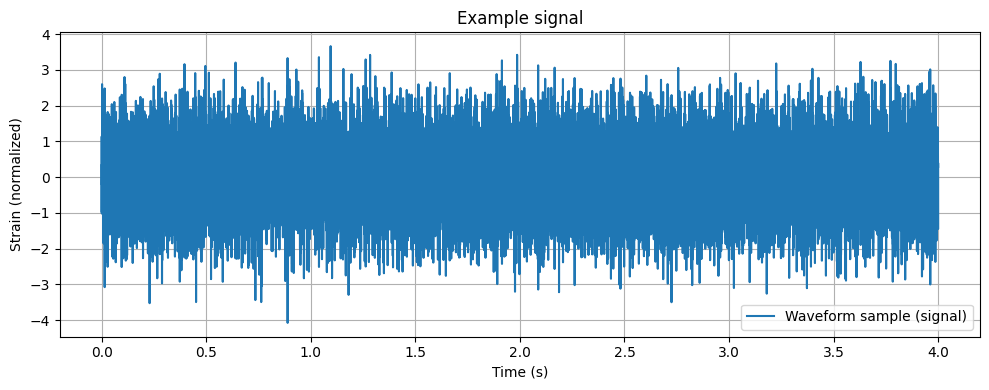

In [10]:

import matplotlib.pyplot as plt
import numpy as np

# Assume X_train was already reshaped to (samples, 16384, 1)

waveform = X_train[i].squeeze()  # Shape: (16384,)

# Generate time axis based on 4096 Hz sample rate
duration = 4  # seconds
sample_rate = 4096
time = np.linspace(0, duration, len(waveform))

plt.figure(figsize=(10, 4))
plt.plot(time, waveform, label='Waveform sample (signal)')
plt.xlabel("Time (s)")
plt.ylabel("Strain (normalized)")
plt.title("Example signal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
